<a href="https://www.kaggle.com/code/yaaangzhou/ps3e17-voteclassifer-baseline-solution?scriptVersionId=133510506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv


<h1 style="font-family:verdana;"> <center> 🎯PS3 E17: Binary Classification of Machine Failures: EDA and Baseline models🚀</center> </h1>

***

# Imports
___

In [2]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import optuna.integration.lightgbm as lgbo

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import r2_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# Models
#Modelling
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [3]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
train = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
origin = pd.read_csv("/kaggle/input/machine-failure-predictions/machine failure.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")

#### ***We used those original datas from this url: https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions***

#### ***It's always helpful when we have more datas.***

In [4]:
train['generated'] = 1
origin['generated'] = 0
test['generated'] = 1

In [5]:
train = pd.concat([train, origin], axis = 0).reset_index(drop = True)
train.drop(['id','UDI','Product ID'],axis = 1, inplace = True)
test.drop(['id','Product ID'],axis = 1, inplace = True)
train.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,generated
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,1
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,1
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,1
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,1
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,1


In [6]:
print('The shape of dataset train is :', train.shape)
print('The shape of dataset test is:', test.shape)

The shape of dataset train is : (146429, 13)
The shape of dataset test is: (90954, 12)


# EDA
___

#### ***We're going to present some distribution plots.***

#### ***First of all, let's check the information of the dataset.***

In [7]:
# summary of train data

def summary(df):
    print(f'data shape is: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

summary(train)

data shape is: (146429, 13)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Type,object,0,0.0,3,NaN,NaN,L,M,L
Air temperature [K],float64,0,0.0,96,295.3,304.5,300.6,302.6,299.3
Process temperature [K],float64,0,0.0,82,305.7,313.8,309.6,312.1,308.5
Rotational speed [rpm],int64,0,0.0,957,1168.0,2886.0,1596,1759,1805
Torque [Nm],float64,0,0.0,615,3.8,76.6,36.1,29.1,26.5
Tool wear [min],int64,0,0.0,246,0.0,253.0,140,200,25
Machine failure,int64,0,0.0,2,0.0,1.0,0,0,0
TWF,int64,0,0.0,2,0.0,1.0,0,0,0
HDF,int64,0,0.0,2,0.0,1.0,0,0,0
PWF,int64,0,0.0,2,0.0,1.0,0,0,0


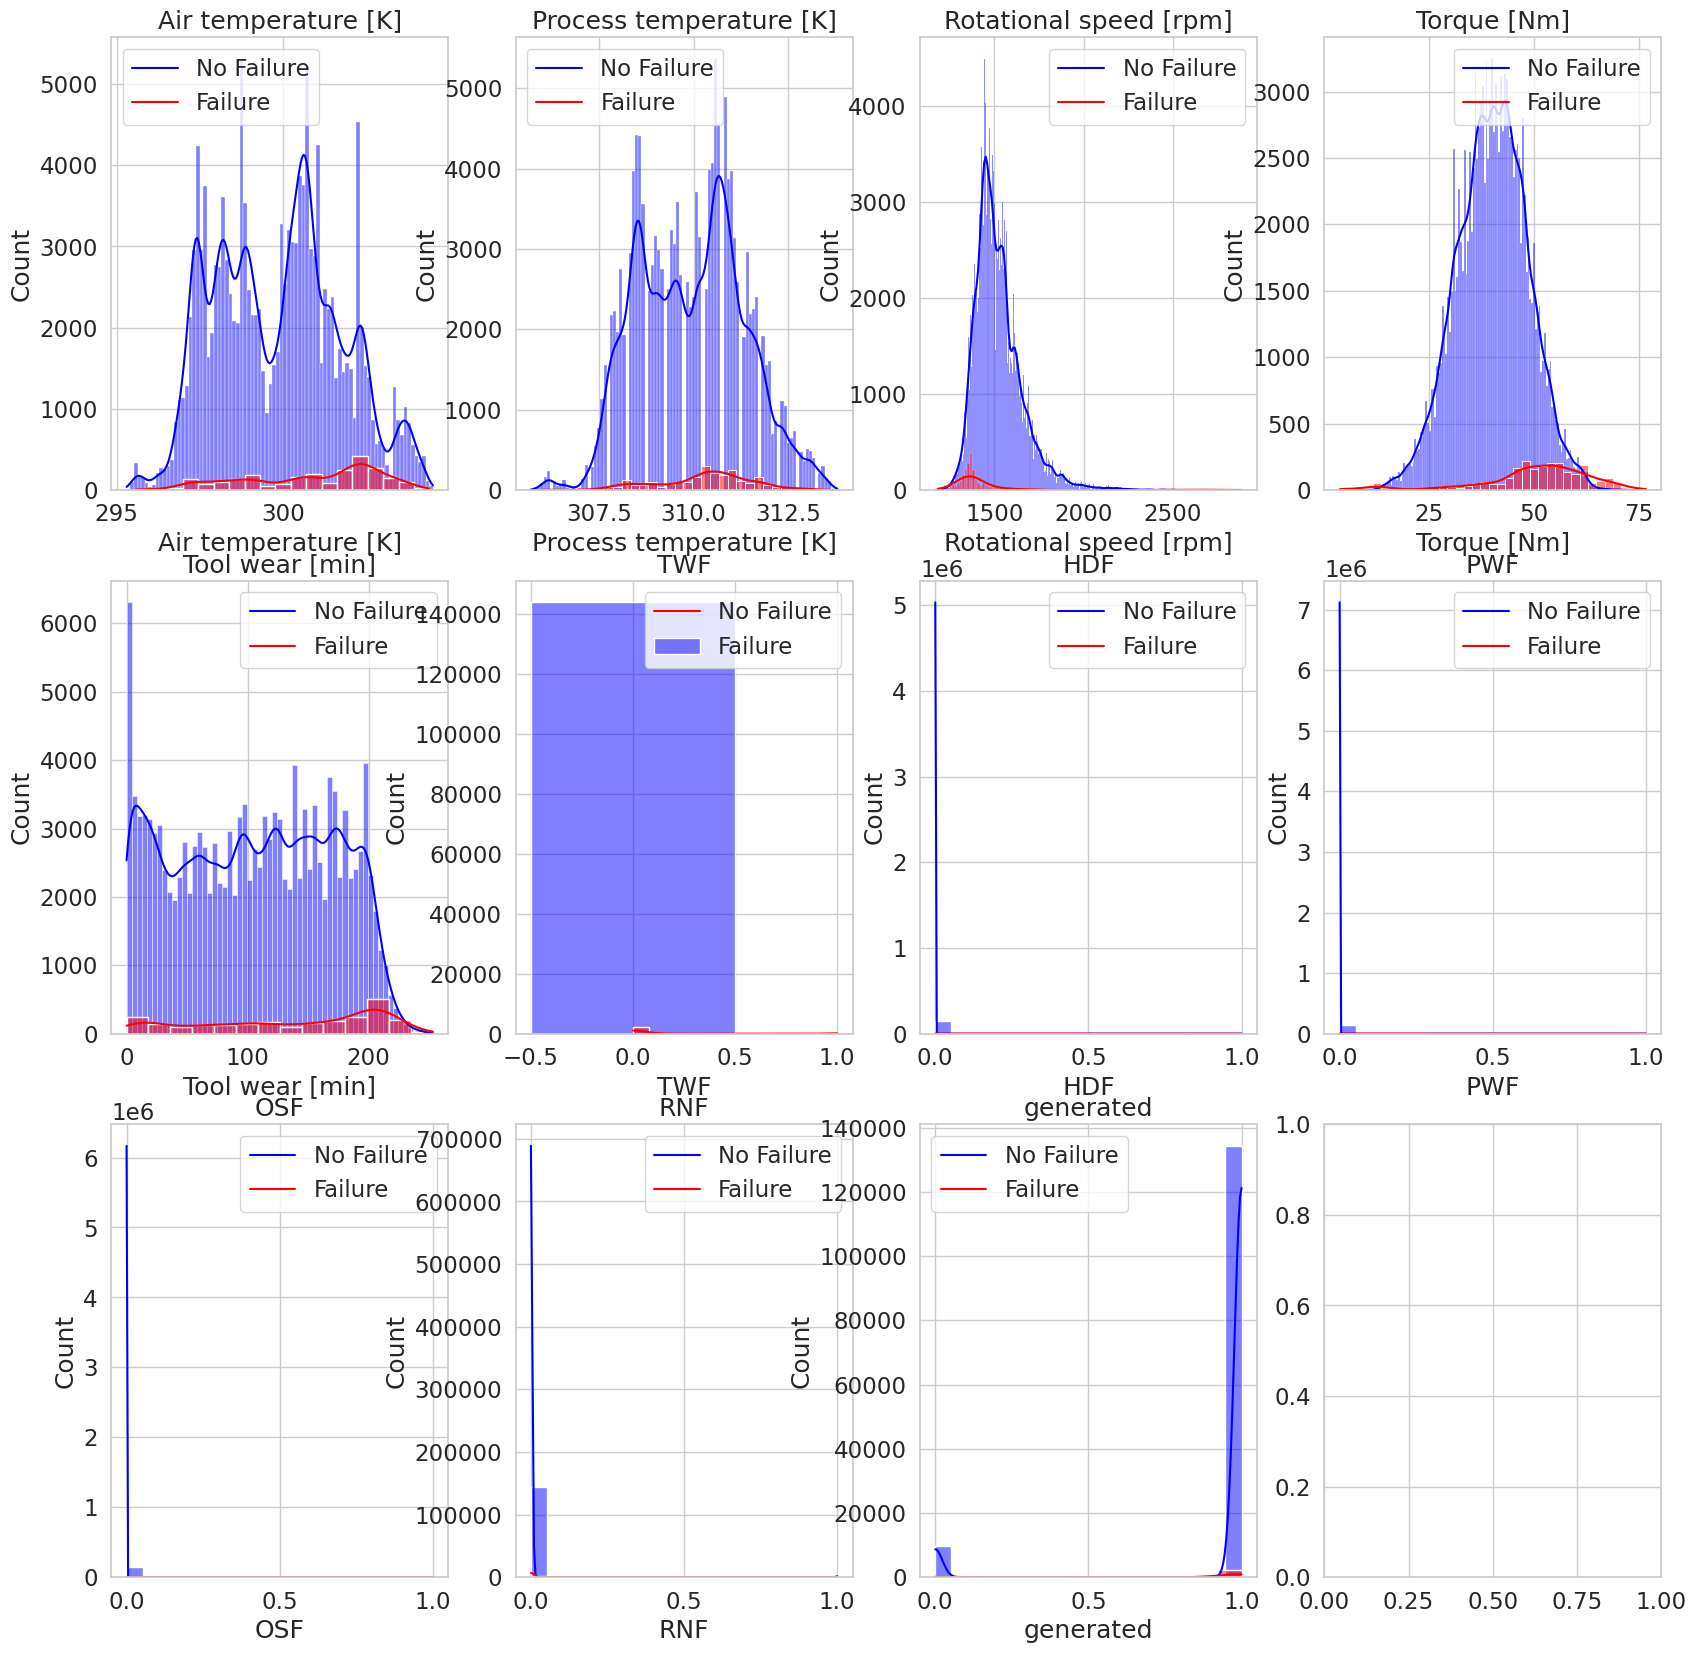

In [8]:
dis_plot = [i for i in train.columns if train[i].dtype != 'object' and i not in ['id','Machine failure']]

def plot_distribution(df):
    num_cols = 4
    num_rows = 3
    sns.set(style='whitegrid', palette='muted', font_scale=1.5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    for ind, col in enumerate(dis_plot):
        if col != 'Marchine failure':
            i = ind // num_cols
            j = ind % num_cols
            sns.histplot(data=df[df['Machine failure'] == 0], x=col, kde=True, ax=axs[i][j], color='blue', label='No Failure')
            sns.histplot(data=df[df['Machine failure'] == 1], x=col, kde=True, ax=axs[i][j], color='red', label='Failure')
            axs[i][j].set_title(col)
            axs[i][j].legend(['No Failure', 'Failure'])
    plt.show()

plot_distribution(train)


#### ***The skewness of some variables is large and the proportion of positive and negative samples differs very much.***
#### ***Therefore, we will need to use some oversampling methods.***

# Data Engineering

___

### ***6 categorical variables in the dataset：`Type`,`TWF`,`HDF`,`PWF`,`OSF`,`RNF`,`generated`***
### ***We don't need to transfomer all of them because most of them are binary variable.***

In [9]:
Y = train['Machine failure']
X = train.drop('Machine failure', axis=1)

X.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,generated
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,1
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,1
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,1
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,1
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,1


In [10]:
var_cate = ['Type','TWF','HDF','PWF','OSF','RNF','generated']

#### ***Here i creat some new features, the original idea is from discussion.***

In [11]:
# onehot encoding and normalization
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

def data_engineering(df,var_cate):
    # rename columns
    for i in df.columns:
        df.columns = df.columns.str.replace('[\[\]]', '', regex=True)

    
    # label encoding for Type colum
    df['Type']=df['Type'].replace({"L":0,"M":1,"H":2})

    # new features
    df['Power'] = df['Torque Nm'] * df['Rotational speed rpm']
    df['Temp_ratio'] = df['Process temperature K'] / df['Air temperature K']
    df['Process temperature C'] = df['Process temperature K'] - 273.15
    df["Air temperature C"] = df["Air temperature K"] - 273.15
    df["temp_C_ratio"] = df["Process temperature C"] / df["Air temperature C"]
    df["Failure Sum"] = (df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"])
    df["tool_wear_speed"] = df["Tool wear min"] * df["Rotational speed rpm"]
    df["torque wear ratio"] = df["Torque Nm"] / (df["Tool wear min"] + 0.0001)
    df["torque times wear"] = df["Torque Nm"] * df["Tool wear min"]

    # normalization
    scaler = StandardScaler()
    for i in [i for i in df.columns if i not in ['Machine failure'] and i not in var_cate]:
        df[i] = scaler.fit_transform(df[[i]])
    
    return df
    

In [12]:
X = data_engineering(X,var_cate)
test = data_engineering(test,var_cate)

# Oversampling
___

In [13]:
from imblearn.over_sampling import SMOTE

print('Shape of train data before oversampling:',X.shape)
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)
print('Shape of train data after oversampling:',X_res.shape)

Shape of train data before oversampling: (146429, 21)
Shape of train data after oversampling: (287884, 21)


### Now we are ready for modeling.

# Modeling

### ***I don't have many options here. Here I simply selected some models and simply used a VotingClassifier to merge them.***

### ***If we are seeking for a better finetuning, we can use Optuna for optimizar each of these weak classifiers.***

In [14]:
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ## GradientBoosting 
        
    gb_md = GradientBoostingClassifier(n_estimators = 500, 
                                       max_depth = 7, 
                                       learning_rate = 0.01,
                                       min_samples_split = 10, 
                                       min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    gb_pred_2 = gb_md.predict_proba(test)[:, 1]
            
    gb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof ROC-AUC score is ==>', gb_score_fold)
    

    ## HistGradientBoosting 
       
    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 1000,
                                             max_depth = 15,
                                             max_bins = 255,
                                             min_samples_leaf = 30,
                                             max_leaf_nodes = 30).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    hist_pred_2 = hist_md.predict_proba(test)[:, 1]

    hist_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof ROC-AUC score is ==>', hist_score_fold)
        
    ## LightGBM
        
    lgb_md = LGBMClassifier(n_estimators = 1000,
                            max_depth = 10,
                            learning_rate = 0.01,
                            num_leaves = 70,
                            reg_alpha = 3,
                            reg_lambda = 3,
                            subsample = 0.7,
                            colsample_bytree = 0.7,
                            device = 'gpu').fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]

    lgb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof ROC-AUC score is ==>', lgb_score_fold)
        
    ## XGBoost 
        
    xgb_md = XGBClassifier(tree_method = 'gpu_hist',
                           colsample_bytree = 0.7, 
                           gamma = 0.8, 
                           learning_rate = 0.01, 
                           max_depth = 8, 
                           min_child_weight = 20, 
                           n_estimators = 1000, 
                           subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    xgb_pred_2 = xgb_md.predict_proba(test)[:, 1]

    xgb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof ROC-AUC score is ==>', xgb_score_fold)

    ## Ensemble 
    
    ens_pred_1 = gb_pred_1 + hist_pred_1 + lgb_pred_1 + xgb_pred_1
    ens_pred_2 = gb_pred_2 + hist_pred_2 + lgb_pred_2 + xgb_pred_2
    
    ens_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i, '==> Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> GradientBoositng oof ROC-AUC score is ==> 0.9573891282009406
Fold 0 ==> HistGradient oof ROC-AUC score is ==> 0.9649682883177157
Fold 0 ==> LightGBM oof ROC-AUC score is ==> 0.9641988036665783
Fold 0 ==> XGBoost oof ROC-AUC score is ==> 0.9660143995535867
Fold 0 ==> Ensemble oof ROC-AUC score is ==> 0.9673243778453748
---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof ROC-AUC score is ==> 0.9522967724056552
Fold 1 ==> HistGradient oof ROC-AUC score is ==> 0.961707795661677
Fold 1 ==> LightGBM oof ROC-AUC score is ==> 0.9566838155430503
Fold 1 ==> XGBoost oof ROC-AUC score is ==> 0.9536987214156265
Fold 1 ==> Ensemble oof ROC-AUC score is ==> 0.9589176506669701
---------------------------------------------------------------
Fold 2 ==> GradientBoositng oof ROC-AUC score is ==> 0.9598337689850169
Fold 2 ==> HistGradient oof ROC-AUC score is ==> 0.9605058684844446
Fold 2 

In [15]:
'''
# Simple Baselines models tests

from tqdm import tqdm

model_table = pd.DataFrame(columns = ['Model Name', 'Score'])
def model_accuracy(model,model_name,X,y):
    print('Starting Iteration for',model_name)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores =[]
    for nfold, (train_idx, valid_idx) in enumerate(tqdm(kf.split(X, y), total=5)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the validation set and calculate MAE
        y_pred = model.predict_proba(X_valid)[:,1]
        roc = roc_auc_score(y_valid, y_pred)
        
        print(f'Iteration : {nfold+1}  ROC AUC: {roc:.5f}')
        
        roc_auc_scores.append(roc)
    
    i=len(model_table)
    model_table.loc[i,'Model Name']=model_name
    model_table.loc[i,'Score']=np.mean(roc_auc_scores)


models = [
      ('CatBoost Classifier',CatBoostClassifier(verbose= False)),
      ('RandomForestClassifier', RandomForestClassifier(random_state=1)),
      ('KNeighborsClassifier', KNeighborsClassifier()),
      ('XGBClassifier', XGBClassifier(random_state=42))
]

for label,model in models:
    model_accuracy(model,label,X_res,Y_res)
    
    
display(model_table.sort_values(by='Score', ascending=False).style.background_gradient(cmap='summer_r'))

print("Baseline Validation done!")

selected_models = [
      ('cat', CatBoostClassifier(verbose= False)),
      ('lgb', LGBMClassifier()),
      ('xgb', XGBClassifier(random_state=42)),
      ('knn', KNeighborsClassifier()),
]

voting_clf = VotingClassifier(estimators = models, voting="soft")

model_accuracy(voting_clf,'Voting',X_res,Y_res)

display(model_table.sort_values(by='Score', ascending=False).style.background_gradient(cmap='summer_r'))


model=voting_clf
model.fit(X_res,Y_res)
preds = model.predict_proba(test)[:,1]

sample_submission['Machine failure'] = preds

sample_submission.to_csv('submission.csv',index=False)
    '''

'\n# Simple Baselines models tests\n\nfrom tqdm import tqdm\n\nmodel_table = pd.DataFrame(columns = [\'Model Name\', \'Score\'])\ndef model_accuracy(model,model_name,X,y):\n    print(\'Starting Iteration for\',model_name)\n    kf = KFold(n_splits=5, shuffle=True, random_state=42)\n    roc_auc_scores =[]\n    for nfold, (train_idx, valid_idx) in enumerate(tqdm(kf.split(X, y), total=5)):\n        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]\n        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]\n    \n        # Train the model\n        model.fit(X_train, y_train)\n\n        # Predict on the validation set and calculate MAE\n        y_pred = model.predict_proba(X_valid)[:,1]\n        roc = roc_auc_score(y_valid, y_pred)\n        \n        print(f\'Iteration : {nfold+1}  ROC AUC: {roc:.5f}\')\n        \n        roc_auc_scores.append(roc)\n    \n    i=len(model_table)\n    model_table.loc[i,\'Model Name\']=model_name\n    model_table.loc[i,\'Score\']=np.mean(roc_auc_sco

In [16]:
gb_cv_score = np.mean(gb_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

baseline_score = pd.DataFrame(index=['cv_score'])

baseline_score['Gradient Boosting'] = gb_cv_score
baseline_score['Histogram Gradient Boosting'] = hist_cv_score
baseline_score['LightGBM'] = lgb_cv_score
baseline_score['XGBoost'] = xgb_cv_score
baseline_score['Ensemble'] = ens_cv_score

In [17]:
gb_preds_test = pd.DataFrame(gb_preds).apply(np.mean, axis = 0)
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

submission['Machine failure'] = hist_preds_test
submission.to_csv('GB_Baseline_submission.csv', index = False)

submission['Machine failure'] = hist_preds_test
submission.to_csv('Hist_Baseline_submission.csv', index = False)

submission['Machine failure'] = lgb_preds_test
submission.to_csv('LightGBM_Baseline_submission.csv', index = False)

submission['Machine failure'] = xgb_preds_test
submission.to_csv('XGBoost_Baseline_submission.csv', index = False)

submission['Machine failure'] = ens_preds_test
submission.to_csv('Ensemble_Baseline_submission.csv', index = False)